# **Problem Statement **



You are working as a data scientist in a global finance company. Over the years, the company has collected basic bank details and gathered a lot of credit-related information. The management wants to build an intelligent system to segregate the people into credit score brackets to reduce the manual efforts.

Task
Given a person’s credit-related information, build a machine learning model that can classify the credit score.

imports

In [3]:
!pip install pyspark
from pyspark.sql import SparkSession
import kagglehub
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.functions import col
from functools import reduce  # import reduce function
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when, regexp_extract
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.ml.linalg import DenseVector
import seaborn as sns
sns.set_palette("Set2")
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline


data

In [4]:
path = kagglehub.dataset_download("parisrohan/credit-score-classification")

In [5]:
# create spark session
spark = SparkSession.builder \
    .appName("CreditScoreClassification") \
    .getOrCreate()

# read the dataset
df = spark.read.csv(path, header=True, inferSchema=True)

# show the first 5 rows
df.show(5)


+------+-----------+--------+-------------+----+-----------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|         Name| Age|        SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+-------------+----+-----------+------

# **Block 1 **
 **Data Cleaning and Exploration**

## 1.1, /1.3
Duplicites, missing values

high percentage of missing values for `Monthly_Inhand_Salary   Type_of_Loan Credit_Score   Num_of_Delayed_Payment  `

In [6]:
def calculate_missing_data(df):
    missing_data = [
        (
            column,
            df.filter(df[column].isNull()).count(),
            (df.filter(df[column].isNull()).count() / df.count()) * 100 if df.count() != 0 else 0
        )
        for column in df.columns
    ]

    missing_df = spark.createDataFrame(missing_data, ["Column", "Missing_Values_Absolute", "Missing_Values_Percentage"])

    return missing_df


missing_df = calculate_missing_data(df)
missing_df.show(missing_df.count(), truncate=False)



+------------------------+-----------------------+-------------------------+
|Column                  |Missing_Values_Absolute|Missing_Values_Percentage|
+------------------------+-----------------------+-------------------------+
|ID                      |0                      |0.0                      |
|Customer_ID             |0                      |0.0                      |
|Month                   |0                      |0.0                      |
|Name                    |15000                  |10.0                     |
|Age                     |0                      |0.0                      |
|SSN                     |0                      |0.0                      |
|Occupation              |0                      |0.0                      |
|Annual_Income           |0                      |0.0                      |
|Monthly_Inhand_Salary   |22500                  |15.0                     |
|Num_Bank_Accounts       |0                      |0.0                      |

no duplicates

In [7]:
# count the number of duplicate rows
duplicates = df.subtract(df.dropDuplicates())

num_duplicates = duplicates.count()

print(f"Number of duplicate rows: {num_duplicates}")


Number of duplicate rows: 0


cleaning data to check for target leakage

In [8]:
print(df.columns)

['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Credit_Score']


In [9]:
print(f"unique customers: {df.select('Customer_ID').distinct().count()}")
print(f"all rows: {df.count()}")

def numberrow(df: DataFrame):
    distinct_customer_ids = df.select("Customer_ID").distinct().limit(2).collect()


    first = distinct_customer_ids[0]["Customer_ID"]
    second = distinct_customer_ids[1]["Customer_ID"]


    five_rows1 = df.filter(df["Customer_ID"] == first).limit(5)


    five_rows2 = df.filter(df["Customer_ID"] == second).limit(5)


    print(f"Five rows for Customer_ID {first}:")
    five_rows1.show()

    print(f"Five rows for Customer_ID {second}:")
    five_rows2.show()


numberrow(df)



unique customers: 12500
all rows: 150000
Five rows for Customer_ID CUS_0x33d2:
+------+-----------+--------+---------+---+-----------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|     Name|Age|        SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Scor

In [10]:
# 1. cols that are not going to be used
df_f = df.drop("SSN")
df_f = df_f.drop("Type_of_Loan")
# 2.
df_f = df_f.drop("Name")
df_f = df_f.fillna({'Credit_Score': 'Missing'})
# 3. fill in occupation based on unique Customer_ID
# we'll assume that each Customer_ID has one occupation and fill in the NULLs with that value
df_f = df_f.withColumn(
    "Occupation",
    F.when(df_f["Occupation"].isNull(), F.first("Occupation").over(Window.partitionBy("Customer_ID"))).otherwise(df_f["Occupation"])
)

df_f = df_f.withColumn(
    "Occupation",
    F.when(df_f["Occupation"]== "_______", F.first("Occupation").over(Window.partitionBy("Customer_ID"))).otherwise(df_f["Occupation"])
)
#3.2 types

# remove special characters from Credit_Utilization_Ratio
df_f = df_f.withColumn(
    "Credit_Utilization_Ratio",
    F.regexp_replace(df_f["Credit_Utilization_Ratio"], "[^0-9.]", "")  # Only keep numbers and decimals
)

# remove special characters from Age (if any)
df_f = df_f.withColumn(
    "Age",
    F.regexp_replace(df_f["Age"], "[^0-9]", "")  # Only keep numbers
)

#Credit_History_Age to months


df_f = df_f.withColumn("Years", when(col("Credit_History_Age").rlike(r"\d+ Years"),
                                 regexp_extract(col("Credit_History_Age"), r"(\d+) Years", 1).cast("int")).otherwise(0))

df_f = df_f.withColumn("Months", when(col("Credit_History_Age").rlike(r"\d+ Month"),
                                  regexp_extract(col("Credit_History_Age"), r"(\d+) Month", 1).cast("int")).otherwise(0))

df_f = df_f.withColumn("Credit_History_Months", when(col("Credit_History_Age").isNull() | (col("Credit_History_Age") == "NA"), 0)
                   .otherwise(col("Years") * 12 + col("Months")))

df_f = df_f.drop("Years", "Months", "Credit_History_Age")

#credit risk
window_spec = Window.partitionBy("Customer_ID").orderBy("Month")

df_f = df_f.withColumn(
    "Previous_Credit_Mix",
    F.lag(df_f["Credit_Mix"]).over(window_spec)
)

df_f = df_f.withColumn(
    "Credit_Mix",
    F.when(df_f["Credit_Mix"] == "_", df_f["Previous_Credit_Mix"]).otherwise(df_f["Credit_Mix"])
)

df_f = df_f.drop("Previous_Credit_Mix")

# 4. fill in NULL Monthly_Inhand_Salary based on Annual_Income / 12
df_f = df_f.withColumn(
    "Monthly_Inhand_Salary",
    F.coalesce(df_f["Monthly_Inhand_Salary"], df_f["Annual_Income"] / 12)
)



# 5. filter out rows where Credit_Score target is null
test_data = df_f.filter(df_f["Credit_Score"].isNull())


df_f = df_f.withColumn(
    "Num_Credit_Inquiries",
    F.coalesce(df_f["Num_Credit_Inquiries"], F.count("Num_Credit_Inquiries").over(Window.partitionBy("Customer_ID")))
)
#remove special characters from ANual_income
df_f = df_f.withColumn(
    "Annual_Income",
    F.regexp_replace(df_f["Annual_Income"], "[^0-9.]", "")
)
#Payment_Behaviour !@9#%8| of the Customer_ID
window_spec = Window.partitionBy('Customer_ID').orderBy('Month')

df_f = df_f.withColumn(
    'Payment_Behaviour',
    F.when(df_f['Payment_Behaviour'] == '!@9#%8|', F.lag('Payment_Behaviour').over(window_spec))
    .otherwise(df_f['Payment_Behaviour'])
)
#special caracters Num_of_Loan
df_f = df_f.withColumn(
    "Num_of_Loan",
    F.regexp_replace(df_f["Num_of_Loan"], "[^0-9.]", "")
)
#special characters from Amount_invested_monthly
df_f = df_f.withColumn(
    "Amount_invested_monthly",
    F.regexp_replace(df_f["Amount_invested_monthly"], "[^0-9.]", "")
)
#Num_of_Delayed_Payment by  Payment_Behaviour
window_spec = Window.partitionBy('Payment_Behaviour')

mean_values = df_f.withColumn(
    'mean_Num_of_Delayed_Payment', F.avg('Num_of_Delayed_Payment').over(window_spec)
)

df_f = mean_values.withColumn(
    'Num_of_Delayed_Payment',
    F.coalesce('Num_of_Delayed_Payment', 'mean_Num_of_Delayed_Payment')
).drop('mean_Num_of_Delayed_Payment')
#amount invested monthly based on paymentbehaviour

window_spec = Window.partitionBy('Payment_Behaviour')

mean_values = df_f.withColumn(
    'mean_Amount_invested_monthly', F.avg('Amount_invested_monthly').over(window_spec)
)

df_f = mean_values.withColumn(
    'Amount_invested_monthly',
    F.coalesce('Amount_invested_monthly', 'mean_Amount_invested_monthly')
).drop('mean_Amount_invested_monthly')

#treating values higher than 100 for age
df_f= df_f.withColumn("Age", when(col("Age") > 100, 100).otherwise(col("Age")))
#shows
df_f.show(10)

numberrow(df_f)

#df_f.select("Payment_Behaviour").distinct().rdd.flatMap(lambda x: x).collect()


+-------+-----------+---------+---+-------------+------------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+---------------------+
|     ID|Customer_ID|    Month|Age|   Occupation|     Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|Credit_History_Months|
+-------+-----------+---------+---+-------------+------------------+---------------------+-----------------+---------------+-------------+--

In [11]:
df_f.select("Payment_Behaviour").distinct().rdd.flatMap(lambda x: x).collect()

['Low_spent_Small_value_payments',
 'High_spent_Medium_value_payments',
 'High_spent_Small_value_payments',
 'Low_spent_Large_value_payments',
 'Low_spent_Medium_value_payments',
 'High_spent_Large_value_payments',
 '!@9#%8']

typecast

In [12]:
df_f.dtypes

[('ID', 'string'),
 ('Customer_ID', 'string'),
 ('Month', 'string'),
 ('Age', 'string'),
 ('Occupation', 'string'),
 ('Annual_Income', 'string'),
 ('Monthly_Inhand_Salary', 'string'),
 ('Num_Bank_Accounts', 'string'),
 ('Num_Credit_Card', 'string'),
 ('Interest_Rate', 'string'),
 ('Num_of_Loan', 'string'),
 ('Delay_from_due_date', 'string'),
 ('Num_of_Delayed_Payment', 'string'),
 ('Changed_Credit_Limit', 'string'),
 ('Num_Credit_Inquiries', 'string'),
 ('Credit_Mix', 'string'),
 ('Outstanding_Debt', 'string'),
 ('Credit_Utilization_Ratio', 'string'),
 ('Payment_of_Min_Amount', 'string'),
 ('Total_EMI_per_month', 'string'),
 ('Amount_invested_monthly', 'string'),
 ('Payment_Behaviour', 'string'),
 ('Monthly_Balance', 'string'),
 ('Credit_Score', 'string'),
 ('Credit_History_Months', 'int')]

In [13]:
def typecast_columns(df):
    column_types = [
        ('Age', 'int'),
        ('Annual_Income', 'double'),
        ('Monthly_Inhand_Salary', 'double'),
        ('Num_Bank_Accounts', 'int'),
        ('Num_Credit_Card', 'int'),
        ('Interest_Rate', 'double'),
        ('Num_of_Loan', 'int'),
        ('Num_of_Delayed_Payment', 'int'),
        ('Changed_Credit_Limit', 'double'),
        ('Num_Credit_Inquiries', 'int'),
        ('Outstanding_Debt', 'double'),
        ('Credit_Utilization_Ratio', 'double'),
        ('Total_EMI_per_month', 'double'),
        ('Amount_invested_monthly', 'double'),
        ('Monthly_Balance', 'double'),
        ('Credit_Score', 'string'),
        ('Credit_History_Months', 'int'),
        ('Delay_from_due_date', 'int')
    ]

    for column, new_type in column_types:
        df = df.withColumn(column, df[column].cast(new_type))

    return df

df_f = typecast_columns(df_f)
df_f.printSchema()


root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Num_of_Loan: integer (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: integer (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)
 |-- Num_Credit_Inquiries: integer (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Payment_of_Min_Amount: string (nullable = true)
 |-- Total_EMI_per_month: double (nullable = true)
 |-- Amount_invested_monthly: double (nullable = true)
 

In [14]:
df_f= df_f.dropna() #dropna
df_f.count()

135904

extreme values

In [15]:
def calculate_extreme_values(df):
    numerical_columns = [col for col, dtype in df.dtypes if dtype in ['int', 'double', 'float']]
    extreme_values_data = []

    total_values_count = df.count()

    stats = df.select(*[F.mean(col).alias(f"{col}_mean") for col in numerical_columns] +
                     [F.stddev(col).alias(f"{col}_stddev") for col in numerical_columns]).first()

    for column in numerical_columns:
        mean = stats[f"{column}_mean"]
        stddev = stats[f"{column}_stddev"]

        lower_bound = mean - 3 * stddev
        upper_bound = mean + 3 * stddev

        extreme_values_count = df.filter((df[column] < lower_bound) | (df[column] > upper_bound)).count()

        extreme_values_percentage = (extreme_values_count / total_values_count) * 100 if total_values_count != 0 else 0

        extreme_values_data.append((column, extreme_values_count, extreme_values_percentage))

    extreme_values_df = spark.createDataFrame(extreme_values_data, ["Column", "Extreme_Values_Count", "Extreme_Values_Percentage"])

    return extreme_values_df

extreme_values_df = calculate_extreme_values(df_f)

extreme_values_pd = extreme_values_df.toPandas()

# Print the result
print(extreme_values_pd)

                      Column  Extreme_Values_Count  Extreme_Values_Percentage
0                        Age                  3810                   2.803449
1              Annual_Income                  1120                   0.824111
2      Monthly_Inhand_Salary                   176                   0.129503
3          Num_Bank_Accounts                  1416                   1.041912
4            Num_Credit_Card                  2278                   1.676183
5              Interest_Rate                  2008                   1.477514
6                Num_of_Loan                   572                   0.420885
7        Delay_from_due_date                    68                   0.050035
8     Num_of_Delayed_Payment                   875                   0.643837
9       Changed_Credit_Limit                   262                   0.192783
10      Num_Credit_Inquiries                  1766                   1.299447
11          Outstanding_Debt                   858              

replacing extreme values with the 1st or 90th percentile values

In [16]:
def winsorize_extreme_values(df, percentile=0.10):
    numerical_columns = [col for col, dtype in df.dtypes if dtype in ['int', 'double', 'float']]

    for column in numerical_columns:
        lower_percentile = df.approxQuantile(column, [percentile], 0.10)[0]
        upper_percentile = df.approxQuantile(column, [1 - percentile], 0.10)[0]

        df = df.withColumn(
            column,
            F.when(df[column] < lower_percentile, lower_percentile)
             .when(df[column] > upper_percentile, upper_percentile)
             .otherwise(df[column])
        )

    return df

df_f = winsorize_extreme_values(df_f)


target leakage
Credit_Score, Changed_Credit_Limit, Payment_Behaviour, and Delay_from_due_date can cause potential leakage

Credit_Score is likely dependent on Credit_Mix

missing values after cleaning the data

credit score ordinal

In [17]:

credit_order = {'Poor': 0, 'Standard': 1, 'Good': 2, 'Missing': 4}

df_f = df_f.withColumn("Credit_Score_Ordinal", when(col("Credit_Score") == "Poor", credit_order["Poor"]) \
              .when(col("Credit_Score") == "Standard", credit_order["Standard"]) \
              .when(col("Credit_Score") == "Good", credit_order["Good"])\
              .when(col("Credit_Score") == "Missing", credit_order["Missing"]))

df_f = df_f.drop('Credit_Score')

In [18]:
df_f.show(5)

+-------+-----------+--------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+---------------------+-------------------+-----------------------+--------------------+------------------+---------------------+--------------------+
|     ID|Customer_ID|   Month| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_History_Months|Credit_Score_Ordinal|
+-------+-----------+--------+----+----------+-------------+---------------------+-----------------+---------------+-------------+----------

In [19]:
missing_df_f = calculate_missing_data(df_f)
missing_df.show(missing_df.count(), truncate=False)
missing_df_f.show(missing_df_f.count(), truncate=False)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

correlation

high correlation of Changed_Credit_Limit and Outstanding_Debt as well as obviously Annual_Income and Monthly_Inhand_Salary, one should be deleted from the model

monthly balance is correlated with ouststanding debt as its likely part of the calculation

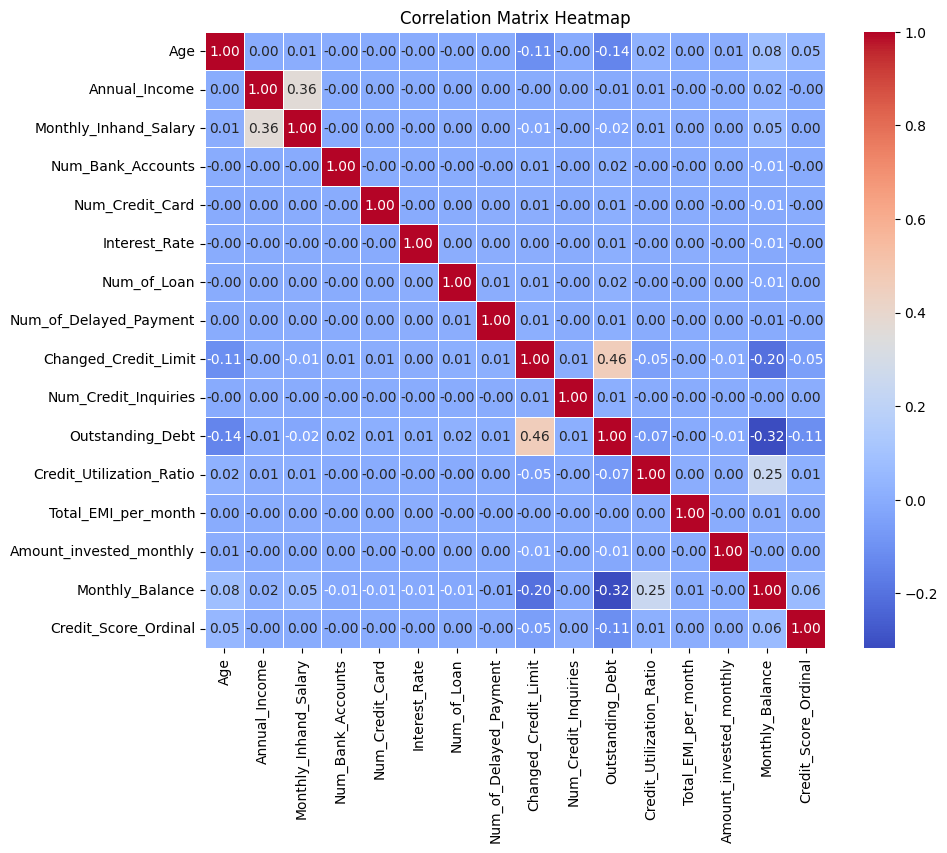

In [20]:

feature_columns = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                   'Interest_Rate', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
                   'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
                   'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', "Credit_Score_Ordinal"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_f_vector = assembler.transform(df_f)

correlation_matrix = Correlation.corr(df_f_vector, "features").head()[0]

matrix_values = correlation_matrix.toArray()

correlation_df = pd.DataFrame(matrix_values, columns=feature_columns, index=feature_columns)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


## 1.2
Exploratory analysis, data types, distribution

In [21]:
# get list of categorical columns
categorical_columns = [col_name for col_name, dtype in df_f.dtypes if dtype == "string" ]

print("Unique values in categorical columns:")
for col_name in categorical_columns:
    # get unique values for the column
    unique_values = df_f.select(col_name).distinct()
    unique_count = unique_values.count()

    # print unique values only if there are less than 20 unique values
    if unique_count < 20:
        unique_list = unique_values.rdd.flatMap(lambda x: x).collect()  # collect unique values
        print(f"{col_name}: {unique_count} unique values")
        print(f"Values: {unique_list}")
    else:
        print(f"{col_name}: {unique_count} unique values (too many to list)")


Unique values in categorical columns:
ID: 135904 unique values (too many to list)
Customer_ID: 12500 unique values (too many to list)
Month: 12 unique values
Values: ['July', 'November', 'February', 'January', 'March', 'October', 'May', 'August', 'April', 'June', 'December', 'September']
Occupation: 16 unique values
Values: ['Scientist', 'Media_Manager', 'Musician', 'Lawyer', 'Teacher', 'Developer', 'Writer', 'Architect', 'Mechanic', 'Entrepreneur', 'Journalist', 'Doctor', 'Engineer', 'Accountant', 'Manager', '_______']
Credit_Mix: 4 unique values
Values: ['_', 'Good', 'Bad', 'Standard']
Payment_of_Min_Amount: 3 unique values
Values: ['NM', 'No', 'Yes']
Payment_Behaviour: 7 unique values
Values: ['High_spent_Medium_value_payments', 'Low_spent_Small_value_payments', 'High_spent_Small_value_payments', 'Low_spent_Large_value_payments', 'Low_spent_Medium_value_payments', '!@9#%8', 'High_spent_Large_value_payments']


In [22]:
# get basic statistics for numerical columns
numerical_columns = [col_name for col_name, dtype in df_f.dtypes if dtype in ["int", "double"]]
print("Basic statistics for numerical columns:")
df_f.select(numerical_columns).describe().show()


Basic statistics for numerical columns:
+-------+------------------+------------------+---------------------+------------------+------------------+-----------------+------------------+-------------------+----------------------+--------------------+--------------------+------------------+------------------------+-------------------+-----------------------+--------------------+---------------------+--------------------+
|summary|               Age|     Annual_Income|Monthly_Inhand_Salary| Num_Bank_Accounts|   Num_Credit_Card|    Interest_Rate|       Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|  Outstanding_Debt|Credit_Utilization_Ratio|Total_EMI_per_month|Amount_invested_monthly|     Monthly_Balance|Credit_History_Months|Credit_Score_Ordinal|
+-------+------------------+------------------+---------------------+------------------+------------------+-----------------+------------------+-------------------+----------------------+---------

graphs

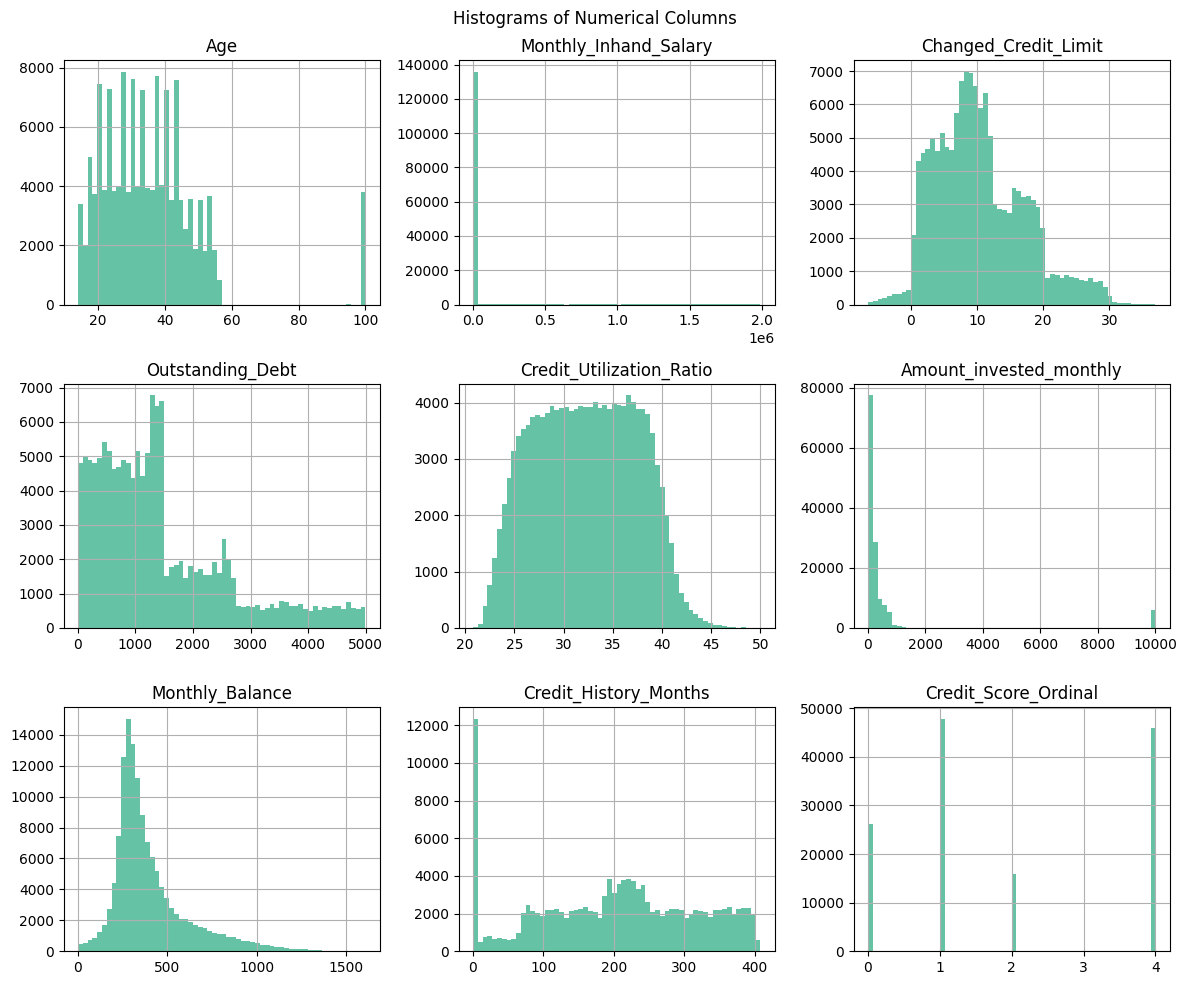

In [23]:
exclude_columns = [
     "Annual_Income", "Num_Bank_Accounts", "Num_Credit_Card",
    "Interest_Rate", "Num_of_Loan", "Delay_from_due_date",
    "Num_of_Delayed_Payment", "Num_Credit_Inquiries", "Total_EMI_per_month"
]

# Get numerical columns excluding the specified ones
hist_data = [col_name for col_name, dtype in df_f.dtypes
             if dtype in ["int", "double"] and col_name not in exclude_columns]

# Convert the selected numerical columns to pandas DataFrame
df_pandas = df_f.select(hist_data).toPandas()

# Plot histograms for each numerical column
df_pandas.hist(bins=60, figsize=(12, 10))
plt.suptitle('Histograms of Numerical Columns')
plt.tight_layout()
plt.show()

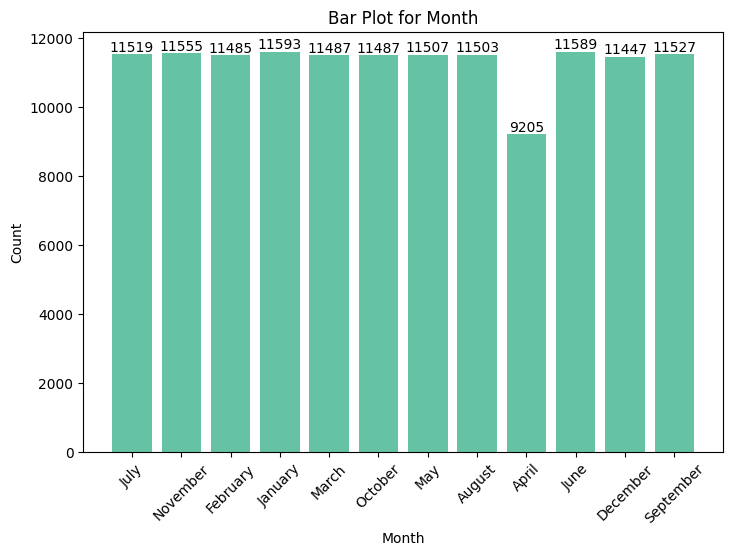

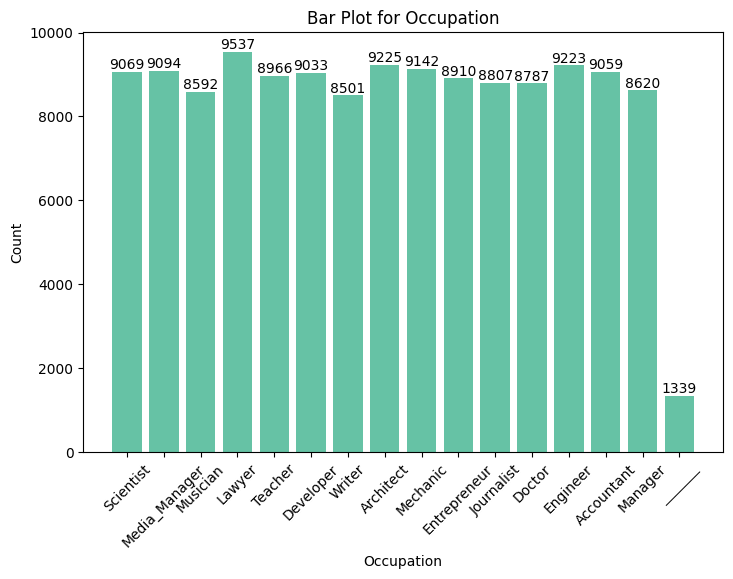

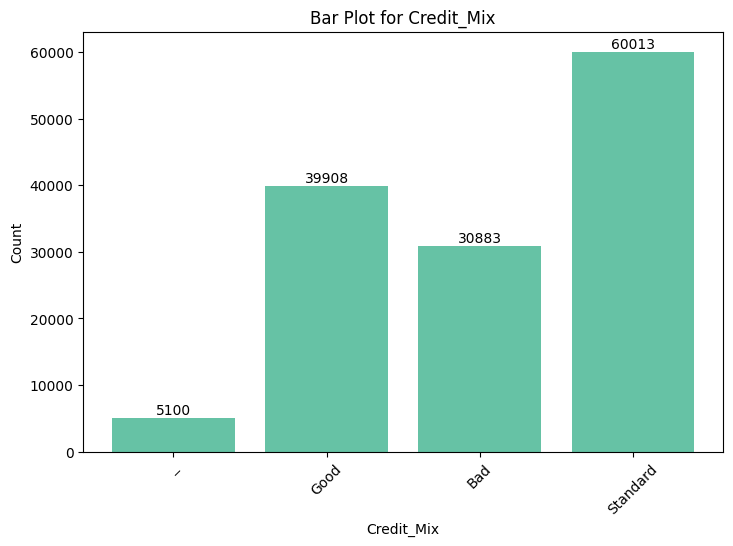

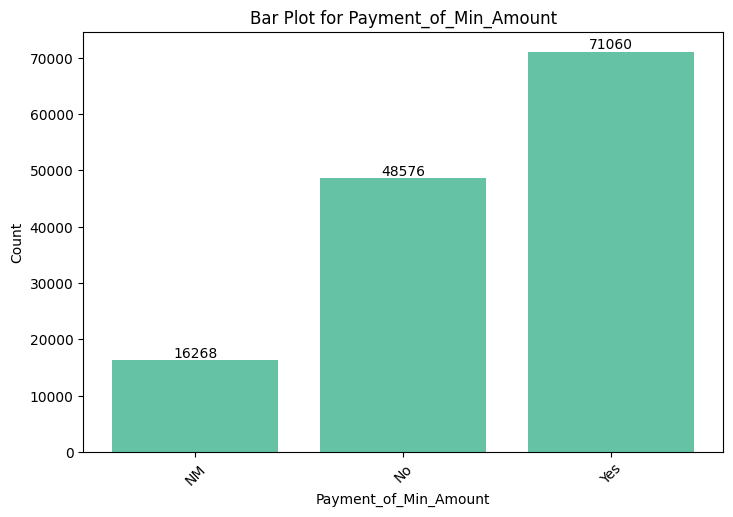

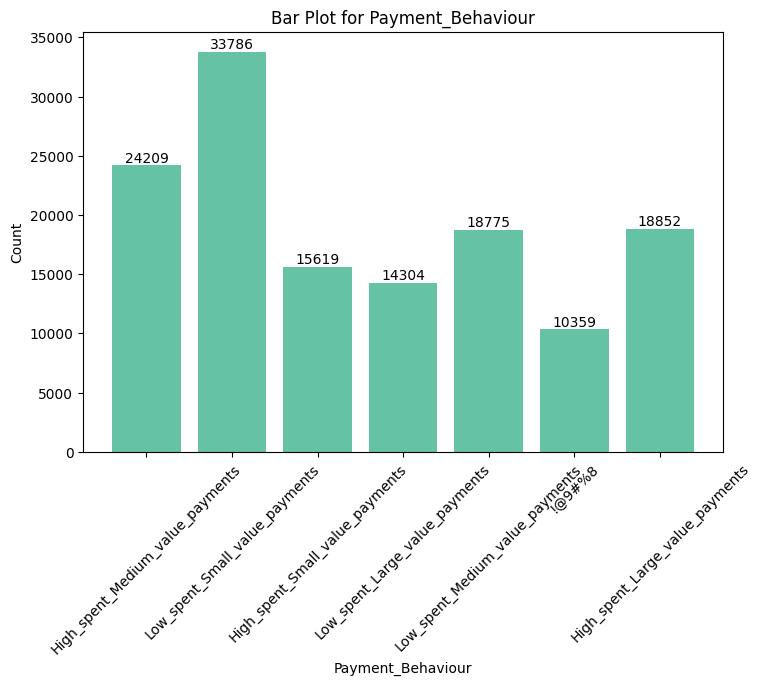

In [24]:
# loop through categorical columns and plot bar plots for those with less than 20 unique values and more than 1 unique value
for col_name in categorical_columns:
    # count unique values for each categorical column if >1 and <20
    unique_count = df_f.select(col_name).distinct().count()

    if unique_count > 1 and unique_count < 20:
        value_counts = df_f.groupBy(col_name).count().toPandas()

        # plot bar plot
        plt.figure(figsize=(8, 6))
        bars = plt.bar(value_counts[col_name], value_counts['count'])

        # annotate each bar with the count value on top
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10)

        plt.title(f"Bar Plot for {col_name}")
        plt.xlabel(col_name)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.subplots_adjust(bottom=0.2, left=0.15, right=0.95, top=0.9)
        plt.show()


# Block 2

Feature engineering


1.   create features
2.   explratory analysis
3.   target leakage



## 2.1

In [25]:
month_mapping = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}

def transform_month_column(df):
    for month, num in month_mapping.items():
        df = df.withColumn("Month", when(col("Month") == month, num).otherwise(col("Month")))

    return df.withColumn("Month", col("Month").cast("int"))

df_f = transform_month_column(df_f)

Amount_invested_monthly - higher amount implies higher final Credit_Score

Payment Timeliness Score - higher score - higher credit score





In [26]:
# 1. Amount_invested_monthly 'Total_EMI_per_month' - 'Monthly_Balance'
df_f = df_f.withColumn(
    'Amount_invested_monthly',
    F.col('Monthly_Balance') - F.col('Total_EMI_per_month')
)


In [27]:
# 2. Payment Timeliness Score
# Assuming columns 'Delay_from_due_date' and 'Num_of_Delayed_Payment'
df_f = df_f.withColumn(
    'Payment_Timeliness_Score',
    1 / (1 + F.col('Delay_from_due_date') + F.col('Num_of_Delayed_Payment'))
)

In [28]:
df_f = df_f.withColumn(
    "Credit_Mix",
    when(F.col("Credit_Mix") == "_", "Missing").otherwise(F.col("Credit_Mix"))
)

df_f = df_f.withColumn(
    "Occupation",
    when(F.col("Occupation") == "_______", "Missing").otherwise(F.col("Occupation"))
)

In [29]:
from pyspark.sql.functions import col, mode, count, when, expr

df_f = df_f.withColumn(
    "Payment_Behaviour",
    F.when(F.col("Payment_Behaviour").like("%!@9#%8%") | F.col("Payment_Behaviour").rlike("!@9#%8"), None).otherwise(F.col("Payment_Behaviour"))
)

mode_df = df_f.groupBy("Customer_ID", "Payment_Behaviour").count() \
              .withColumn("rank", expr("row_number() OVER (PARTITION BY Customer_ID ORDER BY count DESC)")) \
              .filter(col("rank") == 1) \
              .select("Customer_ID", "Payment_Behaviour")


df_f = df_f.join(mode_df.withColumnRenamed("Payment_Behaviour", "Mode_Payment_Behaviour"), on="Customer_ID", how="left")

df_f = df_f.withColumn("Payment_Behaviour",
                       when(col("Payment_Behaviour").isNotNull(), col("Payment_Behaviour"))
                       .otherwise(col("Mode_Payment_Behaviour")))

df_f = df_f.drop("Mode_Payment_Behaviour")

df_f.show(10)

from pyspark.sql.functions import split
df_f1 = df_f.withColumn("Payment_Spent", split(df_f["Payment_Behaviour"], "_")[0]).withColumn("Payment_Value", split(df_f["Payment_Behaviour"], "_")[2])
df_f1 = df_f1.drop("Payment_Behaviour")


spent_order = {"Low": 0, "High": 1}
value_order = {"Small": 0, "Medium": 1, "Large": 2}

#perform ordinal encoding of  Payment_Spent and Payment_Value
df_f1 = df_f1.withColumn("Payment_Spent_Ordinal", when(col("Payment_Spent") == "Low", spent_order["Low"]).otherwise(spent_order["High"])) \
               .withColumn("Payment_Value_Ordinal", when(col("Payment_Value") == "Small", value_order["Small"]) \
                                               .when(col("Payment_Value") == "Medium", value_order["Medium"]) \
                                               .otherwise(value_order["Large"]))

df_f=df_f1

+-----------+-------+-----+----+-------------+------------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+---------------------+-------------------+-----------------------+--------------------+------------------+---------------------+--------------------+------------------------+
|Customer_ID|     ID|Month| Age|   Occupation|     Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_History_Months|Credit_Score_Ordinal|Payment_Timeliness_Score|
+-----------+-------+-----+----+-------------+------------------+---------------

In [30]:
df_f = df_f.drop("Payment_Behaviour_Index", "features", "Payment_Behaviour_Cluster")

occupation categories

In [31]:
from pyspark.sql.functions import col, mean, expr
df_f.drop("Occupation_Type")
q1, q3 = df_f.approxQuantile("Monthly_Inhand_Salary", [0.25, 0.75], 0.01)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

filtered_df = df_f.filter(
    (col("Monthly_Inhand_Salary") >= lower_bound) & (col("Monthly_Inhand_Salary") <= upper_bound)
)

occupation_salary = filtered_df.groupBy("Occupation").agg(mean("Monthly_Inhand_Salary").alias("Avg_Monthly_Salary"))

occupation_salary.show()
percentiles = occupation_salary.approxQuantile("Avg_Monthly_Salary", [0.33, 0.66], 0.01)
low_threshold, high_threshold = percentiles[0], percentiles[1]

occupation_salary = occupation_salary.withColumn(
    "Occupation_Type",
    when(col("Avg_Monthly_Salary") > high_threshold, "High")
    .when(col("Avg_Monthly_Salary") > low_threshold, "Medium")
    .otherwise("Low")
)

occupation_salary.show()
df_f = df_f.join(occupation_salary.select("Occupation", "Occupation_Type"), on="Occupation", how="left")

df_f.select("Occupation", "Monthly_Inhand_Salary", "Occupation_Type").show(10)

df_f.show(10)

+-------------+------------------+
|   Occupation|Avg_Monthly_Salary|
+-------------+------------------+
|    Scientist|4021.7586666744846|
|Media_Manager|3989.4350712676833|
|     Musician|3963.0782350394134|
|       Lawyer|3836.6965555107995|
|      Teacher|3911.7486932784946|
|    Developer| 3899.549135272868|
|       Writer|4006.7054421637445|
|    Architect|  4009.63199926416|
|     Mechanic|3939.7497757985802|
| Entrepreneur| 3969.610377722865|
|   Journalist| 3681.300513218466|
|      Missing|3896.0632227213173|
|       Doctor| 3833.707063910419|
|     Engineer| 3966.890075202808|
|   Accountant|3902.7167647473784|
|      Manager|4004.8620281543904|
+-------------+------------------+

+-------------+------------------+---------------+
|   Occupation|Avg_Monthly_Salary|Occupation_Type|
+-------------+------------------+---------------+
|    Scientist|4021.7586666744846|           High|
|Media_Manager|3989.4350712676833|           High|
|     Musician|3963.0782350394134|         M

In [32]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

window_spec = Window.partitionBy("Customer_ID").orderBy("Month").rowsBetween(Window.unboundedPreceding, 0)

df_f = df_f.withColumn("Occupation_Type_Filled",
                       F.last("Occupation_Type", True).over(window_spec))

df_f.select("Customer_ID", "Month", "Occupation_Type", "Occupation_Type_Filled").show()


+-----------+-----+---------------+----------------------+
|Customer_ID|Month|Occupation_Type|Occupation_Type_Filled|
+-----------+-----+---------------+----------------------+
| CUS_0x1000|    1|            Low|                   Low|
| CUS_0x1000|    2|            Low|                   Low|
| CUS_0x1000|    3|            Low|                   Low|
| CUS_0x1000|    4|            Low|                   Low|
| CUS_0x1000|    5|            Low|                   Low|
| CUS_0x1000|    6|            Low|                   Low|
| CUS_0x1000|    7|            Low|                   Low|
| CUS_0x1000|    8|            Low|                   Low|
| CUS_0x1000|    9|            Low|                   Low|
| CUS_0x1000|   10|            Low|                   Low|
| CUS_0x1000|   11|            Low|                   Low|
| CUS_0x1000|   12|            Low|                   Low|
| CUS_0x1009|    1|         Medium|                Medium|
| CUS_0x1009|    2|         Medium|                Mediu

In [33]:
def encodeOccupations(df, unique_occupations):
    for occupation in unique_occupations:
        if len(occupation.strip()) > 0:
            # Create a new column with a 1 if the occupation matches, else 0
            df = df.withColumn(occupation.strip(), when(df['Occupation'] == occupation.strip(), 1).otherwise(0))
    return df

unique_occupations = df_f.select('Occupation').distinct().rdd.flatMap(lambda x: x).collect()
print(unique_occupations)
df_f = encodeOccupations(df_f, unique_occupations)
df_f = df_f.drop('Occupation')

['Scientist', 'Media_Manager', 'Musician', 'Lawyer', 'Teacher', 'Developer', 'Writer', 'Architect', 'Mechanic', 'Entrepreneur', 'Journalist', 'Missing', 'Doctor', 'Engineer', 'Accountant', 'Manager']


## 2.2

In [34]:
df_f= df_f.dropna() #dropna
df_f.count()

135292

univariate exploratory analysis (type, dist...)

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, count, mean, stddev, min, max


In [36]:

# Define numerical and categorical columns
numeric_cols = ["Payment_Timeliness_Score", "Payment_Spent_Ordinal", "Payment_Value_Ordinal",'Scientist', 'Media_Manager', 'Musician', 'Lawyer', 'Teacher', 'Developer', 'Writer', 'Architect', 'Mechanic', 'Entrepreneur', 'Journalist', 'Missing', 'Doctor', 'Engineer', 'Accountant', 'Manager']
quant_cols = ["Payment_Timeliness_Score"]
categorical_cols = ["Payment_Spent", "Payment_Value", "Occupation_Type"]



In [37]:

# Compute basic statistics for numerical column
df_f.select(
    [mean(col(c)).alias(f"{c}_mean") for c in quant_cols] +
    [stddev(col(c)).alias(f"{c}_stddev") for c in quant_cols]
).show()


+-----------------------------+-------------------------------+
|Payment_Timeliness_Score_mean|Payment_Timeliness_Score_stddev|
+-----------------------------+-------------------------------+
|         0.041353668084502374|            0.05993383770431972|
+-----------------------------+-------------------------------+



In [38]:
# Convert numeric columns to Pandas for visualization
df_numeric = df_f.select(numeric_cols).toPandas()


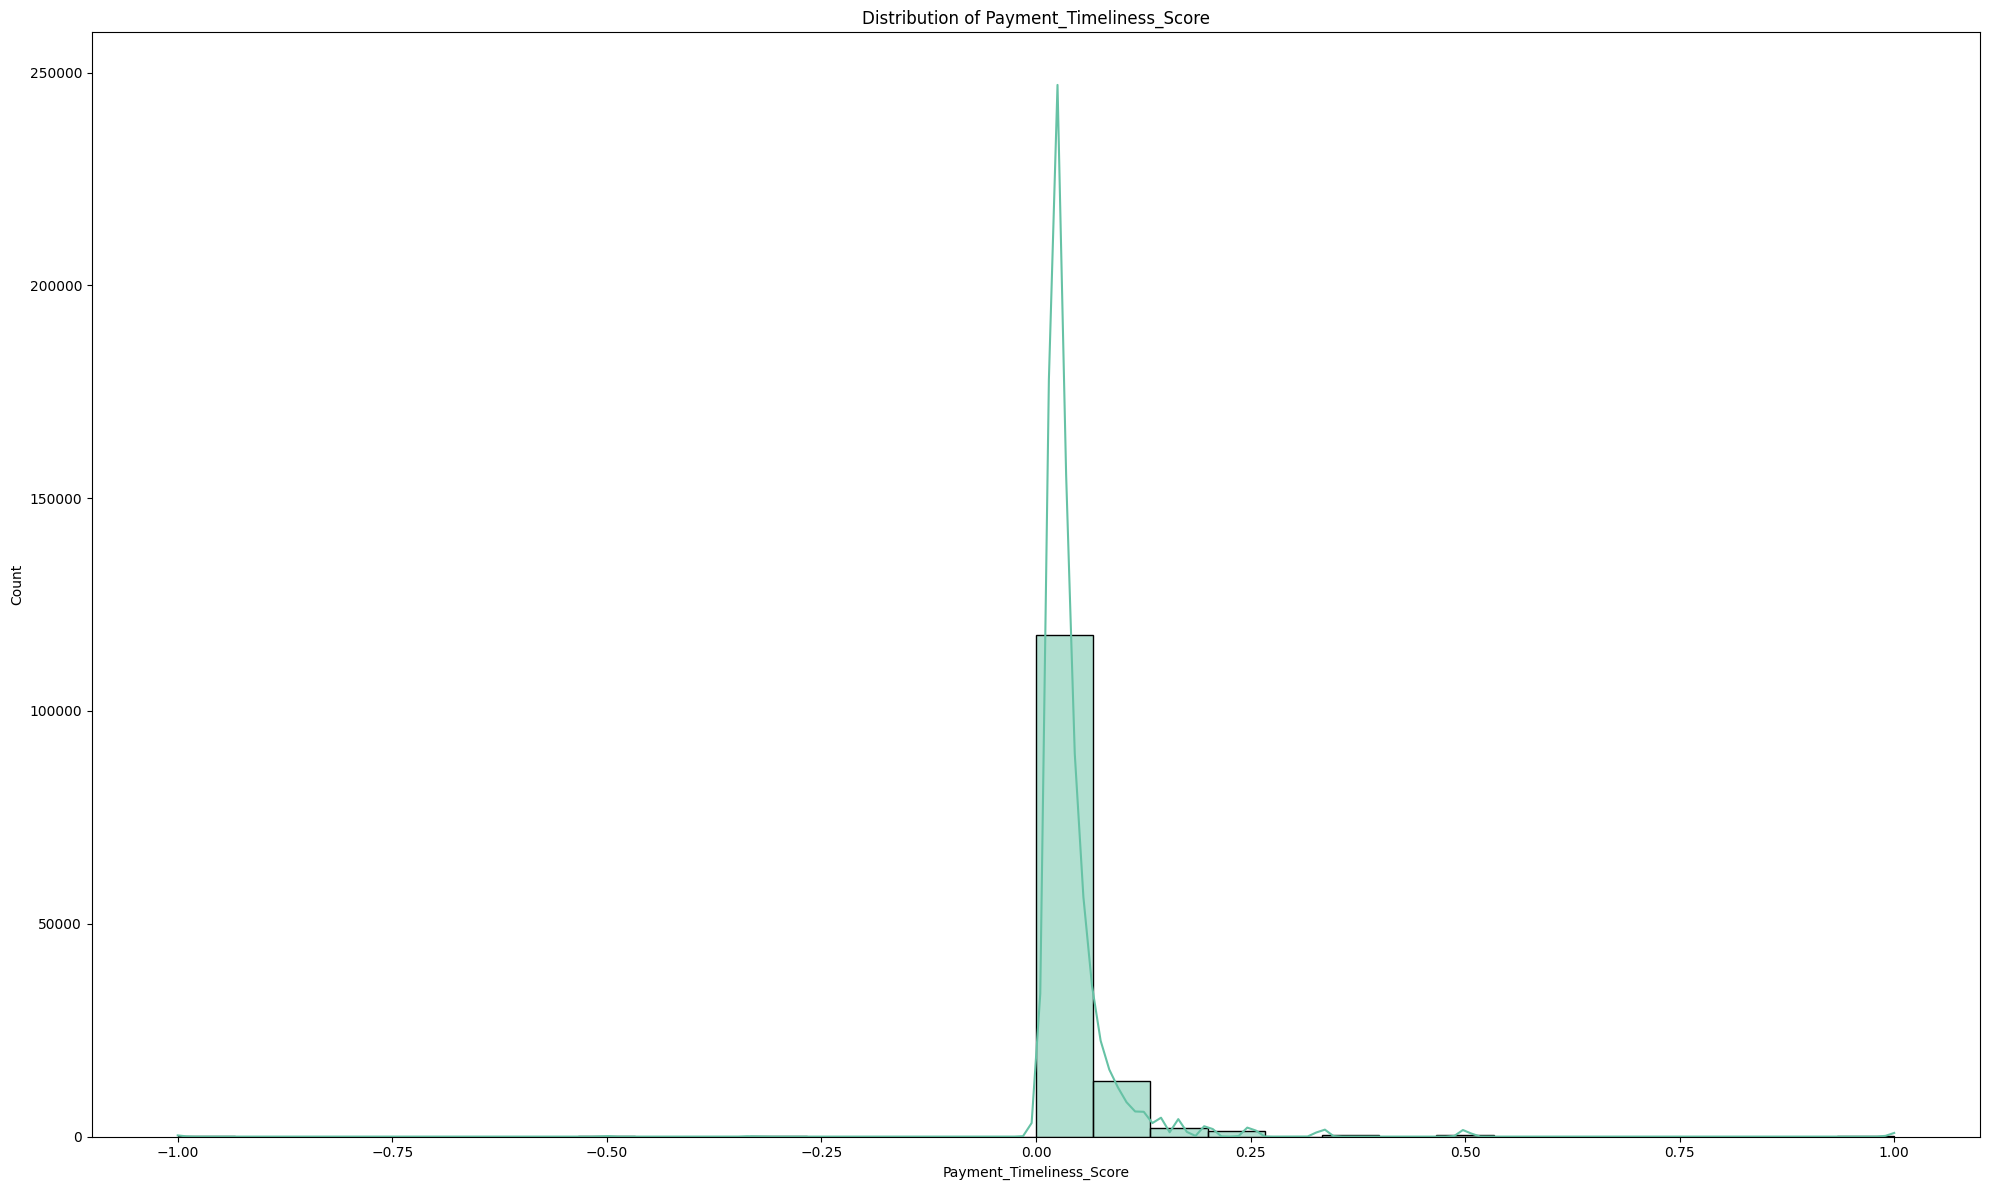

In [39]:
# Plot distribution for numeric columns
plt.figure(figsize=(20, 12))
for i, col_name in enumerate(quant_cols): #change to numeric_cols to see all graphs
    plt.subplot(1, len(quant_cols), i + 1)
    sns.histplot(df_numeric[col_name].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {col_name}")

plt.tight_layout()
plt.show()

In [40]:
# value counts for categorical columns
for col_name in categorical_cols:
    df_f.groupBy(col_name).agg(count("*").alias("count")).orderBy("count", ascending=False).show()

+-------------+-----+
|Payment_Spent|count|
+-------------+-----+
|          Low|72272|
|         High|63020|
+-------------+-----+

+-------------+-----+
|Payment_Value|count|
+-------------+-----+
|        Small|54103|
|       Medium|46428|
|        Large|34761|
+-------------+-----+

+---------------+-----+
|Occupation_Type|count|
+---------------+-----+
|            Low|46316|
|         Medium|44671|
|           High|44305|
+---------------+-----+



In [41]:
from pyspark.sql.functions import when, count

# compute quantiles (0%, 25%, 50%, 75%, 100%)
quantiles = df_f.approxQuantile("Payment_Timeliness_Score", [0.0, 0.25, 0.50, 0.75, 1.0], 0.01)

# bin edges
q_min, q1, q2, q3, q_max = quantiles

df_binned = df_f.withColumn(
    "Score_Bin",
    when(col("Payment_Timeliness_Score") <= q1, "0-25%")
    .when((col("Payment_Timeliness_Score") > q1) & (col("Payment_Timeliness_Score") <= q2), "25-50%")
    .when((col("Payment_Timeliness_Score") > q2) & (col("Payment_Timeliness_Score") <= q3), "50-75%")
    .otherwise("75-100%")
)

df_binned.groupBy("Score_Bin").agg(count("*").alias("Count")).orderBy("Score_Bin").show()


+---------+-----+
|Score_Bin|Count|
+---------+-----+
|    0-25%|35572|
|   25-50%|33220|
|   50-75%|34206|
|  75-100%|32294|
+---------+-----+



## 2.3 3.1

target leakage

In [42]:
from pyspark.sql.functions import col

df_f = df_f.withColumn("Payment_Spent_Ordinal", col("Payment_Spent_Ordinal").cast("int"))
df_f = df_f.withColumn("Payment_Value_Ordinal", col("Payment_Value_Ordinal").cast("int"))
df_f.printSchema()


root
 |-- Customer_ID: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: double (nullable = true)
 |-- Num_Credit_Card: double (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Num_of_Loan: double (nullable = true)
 |-- Delay_from_due_date: double (nullable = true)
 |-- Num_of_Delayed_Payment: double (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Payment_of_Min_Amount: string (nullable = true)
 |-- Total_EMI_per_month: double (nullable = true)
 |-- Amount_invested_monthly: double (nullable = true)
 |-- Monthly_Balance: double (nullable = true)
 |

In [ ]:
from pyspark.sql.functions import corr
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Numeric columns correlation

for col_name in ["Payment_Timeliness_Score", "Payment_Spent_Ordinal", "Payment_Value_Ordinal",'Scientist', 'Media_Manager', 'Musician', 'Lawyer', 'Teacher', 'Developer', 'Writer', 'Architect', 'Mechanic', 'Entrepreneur', 'Journalist', 'Missing', 'Doctor', 'Engineer', 'Accountant', 'Manager']:
    corr_value = df_f.select(corr(col_name, "Credit_Score_Ordinal")).collect()[0][0]
    print(f"Correlation between {col_name} and Credit_Score_Ordinal: {corr_value:.4f}")

Correlation between Payment_Timeliness_Score and Credit_Score_Ordinal: 0.0647
Correlation between Payment_Spent_Ordinal and Credit_Score_Ordinal: 0.0326
Correlation between Payment_Value_Ordinal and Credit_Score_Ordinal: 0.0276
Correlation between Scientist and Credit_Score_Ordinal: -0.0016


occupation type correlation

In [ ]:

# Encode categorical variables
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(df_f) for col in ["Occupation_Type"]]
for indexer in indexers:
    df_f = indexer.transform(df_f)

# Create feature vector
vector_assembler = VectorAssembler(inputCols=["Occupation_Type_index"], outputCol="categorical_features")
df_f = vector_assembler.transform(df_f)

# Compute correlation for categorical features (as a feature vector)
matrix = Correlation.corr(df_f.select("categorical_features"), "categorical_features").head()[0]
correlation_values = matrix.toArray()[:, 0]  # Extract correlation values for Credit_Score

# Print results for categorical features
categorical_cols = [ "Occupation_Type"]
for i, col_name in enumerate(categorical_cols):
    print(f"Correlation between {col_name} (indexed) and Credit_Score_Ordinal: {correlation_values[i]:.4f}")


# Block 3

## 3.1
visualise features relationship with the target

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


In [ ]:

# Select numeric columns + One-Hot Encoded occupation columns
numeric_cols = [
    "Payment_Timeliness_Score", "Payment_Spent_Ordinal", "Payment_Value_Ordinal", "Credit_Score_Ordinal",
    "Scientist", "Media_Manager", "Musician", "Lawyer", "Teacher", "Developer", "Writer",
    "Architect", "Mechanic", "Entrepreneur", "Journalist", "Doctor", "Engineer", "Accountant", "Manager", "Age",
"Monthly_Inhand_Salary",
"Num_Bank_Accounts",
"Num_Credit_Card",
"Num_of_Loan",
"Num_of_Delayed_Payment",
"Num_Credit_Inquiries",
"Outstanding_Debt",
"Total_EMI_per_month",
"Credit_History_Months"
]


vector_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = vector_assembler.transform(df_f).select("features")

# correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]
correlation_array = correlation_matrix.toArray()

# Convert to Pandas DataFrame
correlation_df = pd.DataFrame(correlation_array, index=numeric_cols, columns=numeric_cols)



In [ ]:
#print(correlation_df)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df[['Credit_Score_Ordinal']].sort_values('Credit_Score_Ordinal', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

plt.title("Correlation with Credit_Score_Ordinal")
plt.show()

## 3.2

Key Observations:

**Payment Timeliness Score and Target**:

  The Payment_Timeliness_Score has a negative correlation of -0.214775 with the target variable. This suggests that as the Payment Timeliness Score increases, the target value tends to decrease. This could imply that more timely payments (higher scores) are associated with lower target values.

**Payment Spent Ordinal and Target**:

  Payment_Spent_Ordinal has a negative correlation of -0.076679 with the target. This indicates that as the ordinal payment spent increases, the target value tends to decrease, but the relationship is weak.

**Payment Value Ordinal and Target**:
  Payment_Value_Ordinal shows a negative correlation of -0.089350 with the target, which also indicates a weak negative relationship. As the payment value increases, the target seems to decrease slightly.

**Credit Score Ordinal and Target**:
  
  Credit_Score_Ordinal has a negative correlation of -0.109860 with the target. Higher credit scores appear to correlate with a slightly lower target value, suggesting that individuals with higher credit scores might be associated with a reduced target value.

**Outstanding Debt and Target**:
  
  Outstanding_Debt has a positive correlation of 0.010987 with the target, indicating a very weak positive relationship. As outstanding debt increases, the target value slightly increases.

**Credit History Months and Target**:
  
  Credit_History_Months shows a strong negative correlation of -0.497221 with the target. This suggests that longer credit histories are significantly associated with lower target values. The longer the individual’s credit history, the more likely the target value will decrease.

**Age and Target**:
  
   Age has a negative correlation of -0.138079 with the target, implying that as age increases, the target tends to decrease. However, this correlation is moderate.


---


Weak Correlations:

There are several features that show weak relationships with the target, such as:

    Total EMI per month (0.001000),
    Num_Credit_Card (0.007615),
    Num_of_Loan (0.022025),
    Num_of_Delayed_Payment (0.010987),
    Num_Credit_Inquiries (-0.003051).

These features show minimal impact on the target, indicating that other factors may be more predictive.
Strong Negative Correlations:

The most significant negative correlation is between **Credit_History_Months** and the target (-0.497221), meaning that the longer the credit history, the more likely the target is lower. This might suggest that individuals with longer credit histories might represent a group with better financial stability or behavior, leading to a decrease in the target value.

# Block 4

## 4.1

Standardize continuous variables: We'll standardize the continuous variables where needed (i.e., columns like Age, Monthly_Inhand_Salary, etc.).

Handle categorical variables: We already have one-hot encoded variables for occupation types. We will check that categorical features are properly handled.

Define a target variable: Since Credit_Score_Ordinal is the target, we can use it for the classification.

In [ ]:


#  to be standardized
numeric_cols = [
    "Age", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Num_Credit_Card", "Num_of_Loan", "Num_of_Delayed_Payment",
    "Num_Credit_Inquiries", "Outstanding_Debt", "Total_EMI_per_month", "Credit_History_Months"
]

# categorical columns
categorical_cols = [
    "Occupation_Type_Filled", "Scientist", "Media_Manager", "Musician", "Lawyer", "Teacher", "Developer", "Writer",
    "Architect", "Mechanic", "Entrepreneur", "Journalist", "Doctor", "Engineer", "Accountant", "Manager"
]


# target column
target_col = "Credit_Score_Ordinal"


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.sql import functions as F
from pyspark.ml import Model
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.sql import functions as F

In [ ]:
#stages
# 1. StringIndexer for target variable (Credit_Score_Ordinal)
indexer_target = StringIndexer(inputCol=target_col, outputCol="label")

# 2. StringIndexer for categorical features (Occupation_Type_Filled) - added indexing for this column
indexers_categorical = [
    StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols if col != "Occupation_Type_Filled"
] + [StringIndexer(inputCol="Occupation_Type_Filled", outputCol="Occupation_Type_Filled_index")]  # Index for this column

# 3. OneHotEncoder for categorical features (after indexing)
encoder_categorical = [
    OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_cols
] + [OneHotEncoder(inputCol="Occupation_Type_Filled_index", outputCol="Occupation_Type_Filled_encoded")]  # Encode the indexed column

# 4. VectorAssembler to combine all feature columns
assembler = VectorAssembler(inputCols=numeric_cols + [col + "_encoded" for col in categorical_cols], outputCol="features")

# 5. StandardScaler for numerical features (features column)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# build
stages = [indexer_target] + indexers_categorical + encoder_categorical + [assembler, scaler]
pipeline = Pipeline(stages=stages)

# apply
model = pipeline.fit(df_f)  # Fit the model
processed_df = model.transform(df_f)  # Apply transformations to the data

# save
pipeline_model_path = "/content/pipes"
model.save(pipeline_model_path)

# test
processed_df.select("scaled_features", "label").show(5)
